# Kaggle Stuff
Kaggle has a time limit of an hour so a callback function is used. 

In [1]:
import time 

#let's also import the abstract base class for our callback
from keras.callbacks import Callback

#defining the callback
class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
        
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)

Using TensorFlow backend.


In [2]:
%matplotlib inline
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

from glob import glob
import math
import cv2

# Getting Dataset

In [3]:
!ls ../input/

sample_submission.csv  test  train


Scale the image for faster training

In [4]:
ScaleTo = 100  # px to scale
seed = 7  # fixing random

path = '../input/plant-seedlings-classification/train/*/*.png' 
files = glob(path)
if len(files) == 0:
    path = '../input/train/*/*.png' 
    files = glob(path)



trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
start = dt.datetime.now()

Encode Image Labels

In [6]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
# print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
# print("Number of classes: " + str(num_clases))

# Plot of label types numbers
# trainLabel[0].value_counts().plot(kind='bar')

LabelEncoder()

# Preprocessing (Mask Img)

* Use gaussian blur for remove noise
* Convert color to HSV
* Create mask
* Create boolean mask
* Apply boolean mask and getting image without background

In [7]:
clearTrainImg = []
examples = []
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung

clearTrainImg = np.asarray(clearTrainImg)

# Split Dataset

In [8]:
clearTrainImg = clearTrainImg / 255 #Normalize dataset

In [9]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = clearTrainLabel)

# Model

## Data Augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# datagen = ImageDataGenerator(
#         rotation_range=180,  # randomly rotate images in the range
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally
#         height_shift_range=0.1,  # randomly shift images vertically 
#         horizontal_flip=True,  # randomly flip images horizontally
#         vertical_flip=True  # randomly flip images vertically
#     )  
# datagen.fit(trainX)

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(trainX)

## Model

In [13]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  # Fix seed

In [14]:
# model = Sequential()

# model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.1))

# model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization(axis=3))
# model.add(Dropout(0.1))

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(num_clases, activation='softmax'))

# model.summary()

# # compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model 1

In [15]:
# model = Sequential()
# #CONV
# #only specify the image input dimensions in the first layer.  - initial layers learn only primitive regularities so do not need to have so much units there.
# model.add(Conv2D(filters=64, kernel_size=(10, 10), input_shape=(ScaleTo, ScaleTo, 3), activation='relu')) #now should be 100-10+1 = 91x91 x64
# model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu')) #now should be 91-5+1 = 87x87

# #CNN More filter - 
# model.add(Conv2D(40, kernel_size=5, padding="same", activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(70, kernel_size=3, padding="same", activation = 'relu'))
# model.add(Conv2D(500, kernel_size=3, padding="same", activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(1024, kernel_size=3, padding="valid", activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# #for FCN - 3 layers is practically better than 2 layers but beyond this, it depends on the dataset
# model.add(Flatten())
# model.add(Dense(units=100, activation='relu'  ))
# model.add(Dropout(0.1))
# model.add(Dense(units=100, activation='relu'  ))
# model.add(Dropout(0.1))
# model.add(Dense(units=100, activation='relu'  ))
# model.add(Dropout(0.3))
# #final output layer
# model.add(Dense(num_clases, activation='softmax'))

# model.summary()

In [16]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model 2

In [17]:
model = Sequential()
#CONV
#only specify the image input dimensions in the first layer.  - initial layers learn only primitive regularities so do not need to have so much units there.
model.add(Conv2D(filters=64, kernel_size=(10, 10), input_shape=(ScaleTo, ScaleTo, 3), activation='relu')) #now should be 100-10+1 = 91x91 x64
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu')) #now should be 91-5+1 = 87x87

#CNN More filter - without Max Pooling
model.add(Conv2D(filters=32, kernel_size=(10, 10), activation='relu')) 
model.add(Conv2D(filters=16, kernel_size=(7, 7), activation='relu')) 
model.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu')) 
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu')) #

#for FCN - 3 layers is practically better than 2 layers but beyond this, it depends on the dataset
model.add(Flatten())
model.add(Dense(units=100, activation='relu'  ))
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'  ))
model.add(Dropout(0.1))
model.add(Dense(units=100, activation='relu'  ))
model.add(Dropout(0.3))
#final output layer
model.add(Dense(num_clases, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 32)        51232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 78, 78, 32)        102432    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 16)        25104     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 66, 66, 32)        25120     
_________________________________________________________________
conv2d_6 (Conv2D)    

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model 3
Inspired by https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

In [19]:

# model = Sequential()

# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu', input_shape = (100,100,3)))
# model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))


# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))


# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(Dense(num_clases, activation = "softmax"))

# model.summary()

In [20]:
# from keras.optimizers import RMSprop

# # Define the optimizer
# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [21]:
# Compile the model
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [22]:
from keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
# batch_size = 86

## Fit Model

In [23]:
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# # learning rate reduction
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.4, 
#                                             min_lr=0.00001)

# # checkpoints
# filepath="drive/DataScience/PlantReco/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
#                              verbose=1, save_best_only=True, mode='max')
# filepath="drive/DataScience/PlantReco/weights.last_auto4.hdf5"
# checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
#                                  verbose=1, save_best_only=False, mode='max')

# # all callbacks
# callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

# # fit model
# hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), 
#                            epochs=12, validation_data=(testX, testY), 
#                            steps_per_epoch=trainX.shape[0], callbacks=callbacks_list)




https://www.kaggle.com/danmoller/make-best-use-of-a-kernel-s-limited-uptime-keras

In [24]:
#a function compatible with the on_interrupt handler
def saveWeights(model, elapsed):
    model.save_weights("model_weights.h5")


In [25]:
# callbacks = [TimerCallback(50, on_interrupt=saveWeights)]
# model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), 
#                            epochs=200, validation_data=(testX, testY), 
#                            steps_per_epoch=trainX.shape[0], callbacks=callbacks)


In [26]:
batch_size = 75
epochs = 30
callbacks = [learning_rate_reduction, TimerCallback(50, on_interrupt=saveWeights)]
history = model.fit_generator(datagen.flow(trainX,trainY, batch_size=batch_size), 
                              epochs = epochs, validation_data = (testX,testY),
                            steps_per_epoch=trainX.shape[0] // batch_size
                              , callbacks=callbacks)
# history = model.fit_generator(datagen.flow(trainX,trainY, batch_size=batch_size),
#                               epochs = epochs, validation_data = (testX,testY),
#                             steps_per_epoch=trainX.shape[0] 
#                               , callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
57/57 [==============================] - 19s 328ms/step - loss: 2.4493 - acc: 0.1261 - val_loss: 2.4179 - val_acc: 0.1368
Epoch 2/30
57/57 [==============================] - 12s 217ms/step - loss: 2.4301 - acc: 0.1296 - val_loss: 2.4172 - val_acc: 0.1284
Epoch 3/30
57/57 [==============================] - 13s 219ms/step - loss: 2.4225 - acc: 0.1401 - val_loss: 2.4160 - val_acc: 0.1368
Epoch 4/30
57/57 [==============================] - 13s 221ms/step - loss: 2.4222 - acc: 0.1296 - val_loss: 2.4157 - val_acc: 0.1368

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
57/57 [==============================] - 12s 218ms/step - loss: 2.4237 - acc: 0.1310 - val_loss: 2.4175 - val_acc: 0.1368
Epoch 6/30
57/57 [==============================] - 12s 219ms/step - loss: 2.4235 - acc: 0.1345 - val_loss: 2.4212 - val_acc: 0.1368
Epoch 7/30
57/57 [==============================] - 13s 220ms/step - loss

In [27]:
#check that the weights were saved:
import os
os.listdir(".")

['__notebook__.ipynb', '__output__.json']

In [28]:
#although it uses the same creator function, it's a different model from the previous one
# del(model)
# model2 = createModel()

#load weights - this only works if the model has the same layer types and the same parameters
model.load_weights('model_weights.h5') #model.load_weights("../input/plantrecomodels/weights.best_17-0.96.hdf5")

#evaluate model2
print("\n\nEvaluating model:")
loss, acc = model.evaluate(trainX, trainY)
print('model loss: ' + str(loss))
print('model acc:  ' + str(acc))

#predicting and checking
# predicts = model.predict(trainX[25:35])
# quickCheck(trainX[25:35],trainY[25:35], predicts)

OSError: Unable to open file (unable to open file: name = 'model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [29]:
#trainX, testX, trainY, testY
print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set

4275/4275 [==============================] - 2s 547us/step
[2.415552834572151, 0.13777777774989255]
475/475 [==============================] - 0s 737us/step
[2.41544577498185, 0.13684210532589963]


# Evaluate

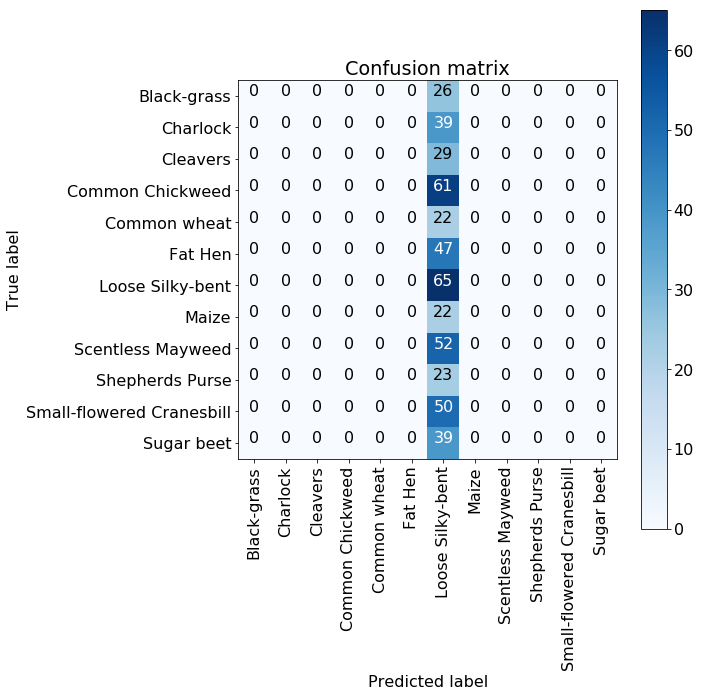

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

1. # Results for Kaggle

In [31]:
# Write result to file
predNum = np.argmax(predY, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)

NameError: name 'testId' is not defined

# Check Time

In [32]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Total time 393 s.
